Why Wrong Mask–Image Matching Happens

In datasets like IDRiD, this can happen for three reasons:

Naming inconsistency
→ e.g., image = IDRiD_52.jpg, mask = IDRiD_052_MA.tif
(extra zero, or suffix like _MA, _HE etc.)

Extension inconsistency
→ image .jpg, mask .tif — fixed by our current loader.

File order mismatch
→ if we rely only on sorted() file lists, order may differ across folders.
(e.g. IDRiD_1.jpg and IDRiD_001.tif come in different positions.)

That’s why using only sorted lists was risky — even though it “runs fine,” it can silently mismatch images and masks.

In [ ]:
import os, glob
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class SafeIDRiDDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, image_size=(256, 256), debug=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_size = image_size
        self.debug = debug

        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")) +
                                glob.glob(os.path.join(img_dir, "*.png")))

        self.lesion_folders = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        img = Image.open(img_path).convert("RGB").resize(self.image_size)

        masks = []
        for lesion in self.lesion_folders:
            lesion_dir = os.path.join(self.mask_dir, lesion)

            # Match file using wildcard pattern (handles suffix variations)
            pattern = os.path.join(lesion_dir, f"{img_name}*.tif")
            mask_candidates = glob.glob(pattern)

            if len(mask_candidates) > 0:
                mask = Image.open(mask_candidates[0]).convert("L").resize(self.image_size)
            else:
                if self.debug:
                    print(f"[⚠️ Missing Mask] {img_name} → lesion {lesion}")
                mask = Image.new("L", self.image_size, 0)
            masks.append(np.array(mask))

        mask = np.stack(masks, axis=0) / 255.0  # normalize
        img = np.array(img).transpose(2, 0, 1) / 255.0

        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask




In [ ]:
# 🗂 Define your dataset directories
base_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation"

train_img_dir = os.path.join(base_dir, "1. Original Images", "a. Training Set")
train_mask_dir = os.path.join(base_dir, "2. All Segmentation Groundtruths", "a. Training Set")

test_img_dir = os.path.join(base_dir, "1. Original Images", "b. Testing Set")
test_mask_dir = os.path.join(base_dir, "2. All Segmentation Groundtruths", "b. Testing Set")
# C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\2. All Segmentation Groundtruths

In [ ]:
dataset = SafeIDRiDDataset(train_img_dir, train_mask_dir,debug=True)
for i in range(3):
    img, mask = dataset[i]
    print(f"\n✅ Image {i} → {os.path.basename(dataset.img_paths[i])}")
    print(f"  Mask shape: {mask.shape}, Nonzero pixels per lesion: {[torch.sum(mask[j]>0).item() for j in range(5)]}")


[⚠️ Missing Mask] IDRiD_01 → lesion 4. Soft Exudates

✅ Image 0 → IDRiD_01.jpg
  Mask shape: torch.Size([5, 256, 256]), Nonzero pixels per lesion: [129, 348, 1360, 0, 1233]
[⚠️ Missing Mask] IDRiD_02 → lesion 4. Soft Exudates

✅ Image 1 → IDRiD_02.jpg
  Mask shape: torch.Size([5, 256, 256]), Nonzero pixels per lesion: [223, 254, 1729, 0, 1178]

✅ Image 2 → IDRiD_03.jpg
  Mask shape: torch.Size([5, 256, 256]), Nonzero pixels per lesion: [327, 1646, 3777, 32, 1378]


In [ ]:
lesion_counts = [0]*5
for i in range(len(dataset)):
    _, mask = dataset[i]
    for j in range(5):
        if torch.sum(mask[j] > 0).item() > 0:
            lesion_counts[j] += 1

lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
for name, count in zip(lesion_names, lesion_counts):
    print(f"{name:20}: {count} images contain this lesion")


[⚠️ Missing Mask] IDRiD_01 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_02 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_04 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_05 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_06 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_07 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_09 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_10 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_11 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_12 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_15 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_16 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_20 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_21 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_24 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_26 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_27 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_28 → lesion 4. Soft Exudates
[⚠️ Missing Mask] IDRiD_29 → lesion 4. Soft Ex

To ensure robust training and prevent incorrect supervision, we implemented a strict filename-based mask matching strategy. Each fundus image is matched only with its corresponding lesion masks using exact prefix comparison. In the absence of a specific lesion annotation, a blank placeholder mask is used. This prevents data misalignment and silent label noise, ensuring high-quality supervision for our UNet training.

___

Model Training

In [ ]:
from torch.utils.data import DataLoader

train_dataset = SafeIDRiDDataset(
    img_dir=r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set",
    mask_dir=r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\2. All Segmentation Groundtruths\a. Training Set",
    debug=False
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)


That was for validation/debugging — to check if any mask is missing or mismatched.
Now that you’ve confirmed the dataset is correct (and only 2 expected missing masks exist),
we don’t need those prints anymore — it would spam the console during training.

So what happens with debug=False

When debug=False, the loader:

Silently skips missing masks

Loads all valid pairs cleanly

Keeps your console neat while training

Internally, it still fills missing ones with blank masks (Image.new("L", self.image_size, 0)) —
so the model won’t crash even if 1–2 masks are missing.

__

Loss Function

Use Weighted BCE + Dice Loss — this helps balance classes (since small lesions like microaneurysms can vanish otherwise).

Why this combination works:

BCE handles pixel-level classification (foreground/background)

Dice helps the model learn overlapping area accuracy, not just individual pixels

Weighted combo balances both.

In [ ]:
import torch
import torch.nn as nn

# -------------------------------
# Weighted BCE + Dice Loss
# -------------------------------
class WeightedBCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight

    def forward(self, preds, targets):
        bce = self.bce(preds, targets)

        # Dice loss
        smooth = 1e-6
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum(dim=(2,3))
        dice = (2. * intersection + smooth) / (preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + smooth)
        dice_loss = 1 - dice.mean()

        total_loss = self.bce_weight * bce + (1 - self.bce_weight) * dice_loss
        return total_loss


In [ ]:
# -----------------------
# MODEL IMPORT (use your existing UNet)
# -----------------------
# from your_model_file import UNet
# model = UNet(n_classes=5).to(device)

# -------------------------------
# UNet Model (same as inference)
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

NameError: name 'nn' is not defined

In [ ]:
import torch.optim as optim

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)

criterion = WeightedBCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import os
from tqdm import tqdm

EPOCHS = 40
save_path = "itworksunet.pth"

best_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    scheduler.step(train_loss)

    print(f"🧠 Epoch [{epoch+1}/{EPOCHS}] | Avg Loss: {train_loss:.6f}")

    # Save best model
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved Best Model (Loss: {best_loss:.6f})")

print(" Training completed.")


Epoch [1/40]: 100%|██████████| 27/27 [02:22<00:00,  5.29s/it]


🧠 Epoch [1/40] | Avg Loss: 0.701957
✅ Saved Best Model (Loss: 0.701957)


Epoch [2/40]: 100%|██████████| 27/27 [04:11<00:00,  9.32s/it]


🧠 Epoch [2/40] | Avg Loss: 0.655500
✅ Saved Best Model (Loss: 0.655500)


Epoch [3/40]: 100%|██████████| 27/27 [02:08<00:00,  4.74s/it]


🧠 Epoch [3/40] | Avg Loss: 0.640474
✅ Saved Best Model (Loss: 0.640474)


Epoch [4/40]: 100%|██████████| 27/27 [01:57<00:00,  4.35s/it]


🧠 Epoch [4/40] | Avg Loss: 0.623110
✅ Saved Best Model (Loss: 0.623110)


Epoch [5/40]: 100%|██████████| 27/27 [02:04<00:00,  4.60s/it]


🧠 Epoch [5/40] | Avg Loss: 0.604345
✅ Saved Best Model (Loss: 0.604345)


Epoch [6/40]: 100%|██████████| 27/27 [01:58<00:00,  4.40s/it]


🧠 Epoch [6/40] | Avg Loss: 0.589351
✅ Saved Best Model (Loss: 0.589351)


Epoch [7/40]: 100%|██████████| 27/27 [01:59<00:00,  4.44s/it]


🧠 Epoch [7/40] | Avg Loss: 0.576003
✅ Saved Best Model (Loss: 0.576003)


Epoch [8/40]: 100%|██████████| 27/27 [01:52<00:00,  4.15s/it]


🧠 Epoch [8/40] | Avg Loss: 0.563281
✅ Saved Best Model (Loss: 0.563281)


Epoch [9/40]: 100%|██████████| 27/27 [01:50<00:00,  4.11s/it]


🧠 Epoch [9/40] | Avg Loss: 0.550439
✅ Saved Best Model (Loss: 0.550439)


Epoch [10/40]: 100%|██████████| 27/27 [01:50<00:00,  4.10s/it]


🧠 Epoch [10/40] | Avg Loss: 0.538418
✅ Saved Best Model (Loss: 0.538418)


Epoch [11/40]: 100%|██████████| 27/27 [02:00<00:00,  4.45s/it]


🧠 Epoch [11/40] | Avg Loss: 0.526679
✅ Saved Best Model (Loss: 0.526679)


Epoch [12/40]: 100%|██████████| 27/27 [02:03<00:00,  4.59s/it]


🧠 Epoch [12/40] | Avg Loss: 0.515213
✅ Saved Best Model (Loss: 0.515213)


Epoch [13/40]: 100%|██████████| 27/27 [01:51<00:00,  4.12s/it]


🧠 Epoch [13/40] | Avg Loss: 0.504285
✅ Saved Best Model (Loss: 0.504285)


Epoch [14/40]: 100%|██████████| 27/27 [01:52<00:00,  4.16s/it]


🧠 Epoch [14/40] | Avg Loss: 0.493627
✅ Saved Best Model (Loss: 0.493627)


Epoch [15/40]: 100%|██████████| 27/27 [01:47<00:00,  3.97s/it]


🧠 Epoch [15/40] | Avg Loss: 0.483651
✅ Saved Best Model (Loss: 0.483651)


Epoch [16/40]: 100%|██████████| 27/27 [01:48<00:00,  4.01s/it]


🧠 Epoch [16/40] | Avg Loss: 0.473878
✅ Saved Best Model (Loss: 0.473878)


Epoch [17/40]: 100%|██████████| 27/27 [01:47<00:00,  3.98s/it]


🧠 Epoch [17/40] | Avg Loss: 0.464613
✅ Saved Best Model (Loss: 0.464613)


Epoch [18/40]: 100%|██████████| 27/27 [01:47<00:00,  3.98s/it]


🧠 Epoch [18/40] | Avg Loss: 0.455914
✅ Saved Best Model (Loss: 0.455914)


Epoch [19/40]: 100%|██████████| 27/27 [01:46<00:00,  3.96s/it]


🧠 Epoch [19/40] | Avg Loss: 0.447211
✅ Saved Best Model (Loss: 0.447211)


Epoch [20/40]: 100%|██████████| 27/27 [01:47<00:00,  3.97s/it]


🧠 Epoch [20/40] | Avg Loss: 0.438816
✅ Saved Best Model (Loss: 0.438816)


Epoch [21/40]: 100%|██████████| 27/27 [01:49<00:00,  4.05s/it]


🧠 Epoch [21/40] | Avg Loss: 0.430942
✅ Saved Best Model (Loss: 0.430942)


Epoch [22/40]: 100%|██████████| 27/27 [01:47<00:00,  3.98s/it]


🧠 Epoch [22/40] | Avg Loss: 0.423311
✅ Saved Best Model (Loss: 0.423311)


Epoch [23/40]: 100%|██████████| 27/27 [01:47<00:00,  3.97s/it]


🧠 Epoch [23/40] | Avg Loss: 0.416353
✅ Saved Best Model (Loss: 0.416353)


Epoch [24/40]: 100%|██████████| 27/27 [02:08<00:00,  4.75s/it]


🧠 Epoch [24/40] | Avg Loss: 0.409953
✅ Saved Best Model (Loss: 0.409953)


Epoch [25/40]: 100%|██████████| 27/27 [01:47<00:00,  3.99s/it]


🧠 Epoch [25/40] | Avg Loss: 0.403756
✅ Saved Best Model (Loss: 0.403756)


Epoch [26/40]: 100%|██████████| 27/27 [01:48<00:00,  4.03s/it]


🧠 Epoch [26/40] | Avg Loss: 0.398814
✅ Saved Best Model (Loss: 0.398814)


Epoch [27/40]: 100%|██████████| 27/27 [01:49<00:00,  4.04s/it]


🧠 Epoch [27/40] | Avg Loss: 0.393061
✅ Saved Best Model (Loss: 0.393061)


Epoch [28/40]: 100%|██████████| 27/27 [01:52<00:00,  4.17s/it]


🧠 Epoch [28/40] | Avg Loss: 0.387985
✅ Saved Best Model (Loss: 0.387985)


Epoch [29/40]: 100%|██████████| 27/27 [02:14<00:00,  4.99s/it]


🧠 Epoch [29/40] | Avg Loss: 0.383134
✅ Saved Best Model (Loss: 0.383134)


Epoch [30/40]: 100%|██████████| 27/27 [01:48<00:00,  4.03s/it]


🧠 Epoch [30/40] | Avg Loss: 0.378399
✅ Saved Best Model (Loss: 0.378399)


Epoch [31/40]: 100%|██████████| 27/27 [02:21<00:00,  5.25s/it]


🧠 Epoch [31/40] | Avg Loss: 0.374513
✅ Saved Best Model (Loss: 0.374513)


Epoch [32/40]: 100%|██████████| 27/27 [02:30<00:00,  5.57s/it]


🧠 Epoch [32/40] | Avg Loss: 0.369998
✅ Saved Best Model (Loss: 0.369998)


Epoch [33/40]: 100%|██████████| 27/27 [02:23<00:00,  5.30s/it]


🧠 Epoch [33/40] | Avg Loss: 0.365799
✅ Saved Best Model (Loss: 0.365799)


Epoch [34/40]: 100%|██████████| 27/27 [02:30<00:00,  5.59s/it]


🧠 Epoch [34/40] | Avg Loss: 0.362191
✅ Saved Best Model (Loss: 0.362191)


Epoch [35/40]: 100%|██████████| 27/27 [02:12<00:00,  4.92s/it]


🧠 Epoch [35/40] | Avg Loss: 0.358631
✅ Saved Best Model (Loss: 0.358631)


Epoch [36/40]: 100%|██████████| 27/27 [01:58<00:00,  4.38s/it]


🧠 Epoch [36/40] | Avg Loss: 0.355507
✅ Saved Best Model (Loss: 0.355507)


Epoch [37/40]: 100%|██████████| 27/27 [01:49<00:00,  4.07s/it]


🧠 Epoch [37/40] | Avg Loss: 0.352241
✅ Saved Best Model (Loss: 0.352241)


Epoch [38/40]: 100%|██████████| 27/27 [02:06<00:00,  4.70s/it]


🧠 Epoch [38/40] | Avg Loss: 0.349352
✅ Saved Best Model (Loss: 0.349352)


Epoch [39/40]: 100%|██████████| 27/27 [02:10<00:00,  4.82s/it]


🧠 Epoch [39/40] | Avg Loss: 0.346444
✅ Saved Best Model (Loss: 0.346444)


Epoch [40/40]: 100%|██████████| 27/27 [01:46<00:00,  3.93s/it]

🧠 Epoch [40/40] | Avg Loss: 0.343948
✅ Saved Best Model (Loss: 0.343948)
 Training completed.


Find Best Threshhold Value

Output min: 1.126248205807201e-09 max: 0.9922356009483337


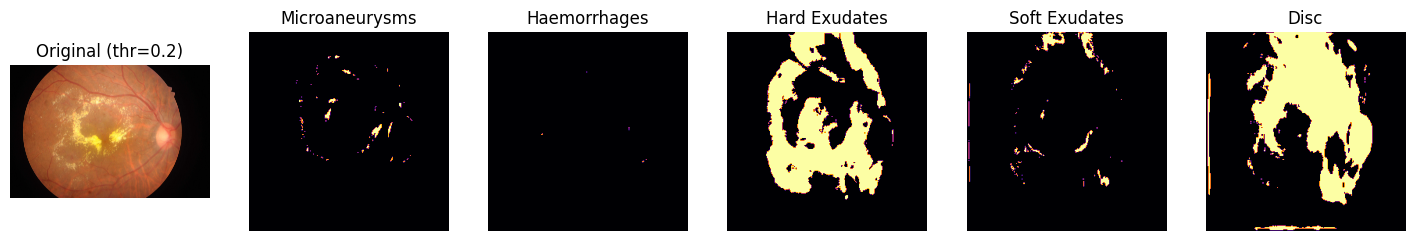

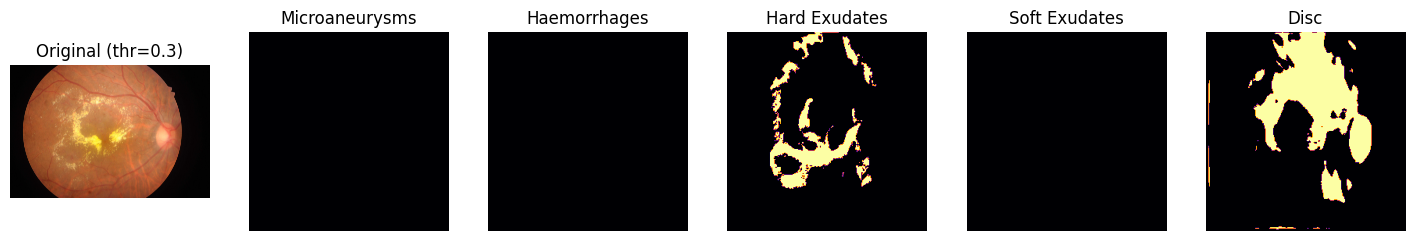

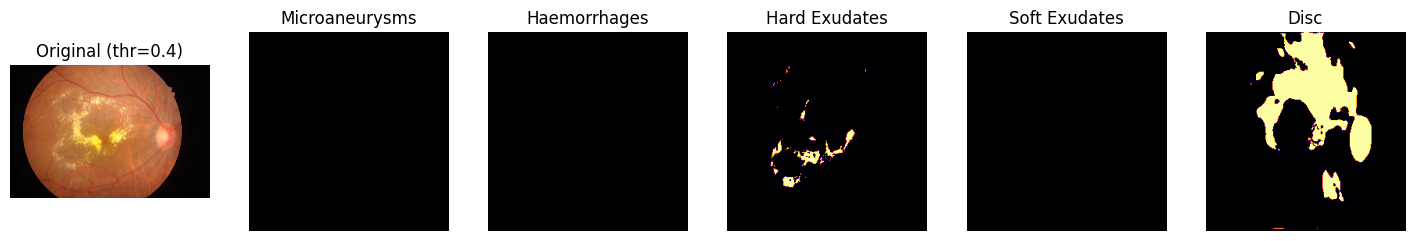

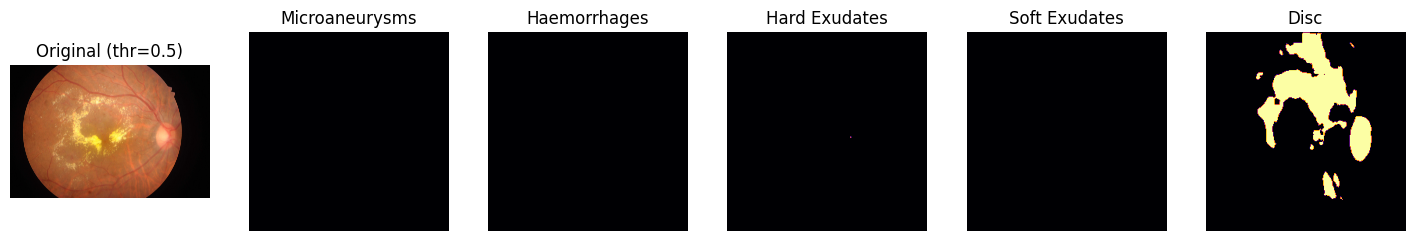

In [ ]:
# Threshold visualization (optional)
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
IMG_SIZE = 256  # or 512 — whichever you trained with

model.eval()
sample_image = Image.open(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_66.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))

print("Output min:", output.min().item(), "max:", output.max().item())

for thr in [0.2, 0.3, 0.4, 0.5]:
    preds = (output > thr).float().squeeze(0).cpu().numpy()
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    axes[0].imshow(sample_image)
    axes[0].set_title(f"Original (thr={thr})")
    axes[0].axis("off")

    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
    for i in range(5):
        axes[i+1].imshow(preds[i], cmap="inferno")
        axes[i+1].set_title(lesion_names[i])
        axes[i+1].axis("off")
    plt.show()


Output min: 1.126248205807201e-09 max: 0.9922356009483337


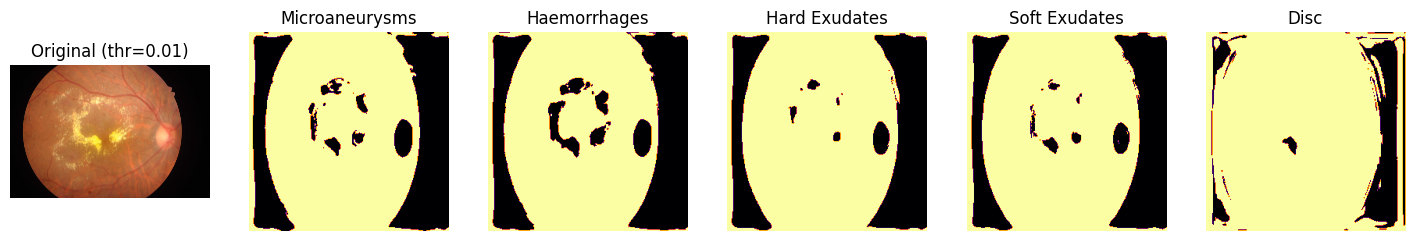

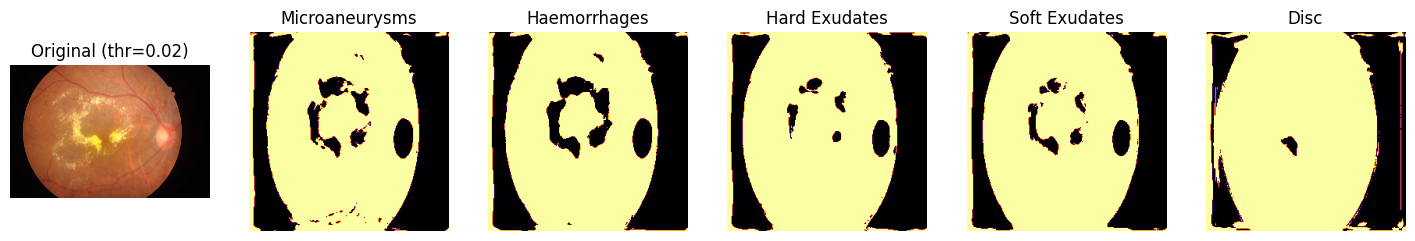

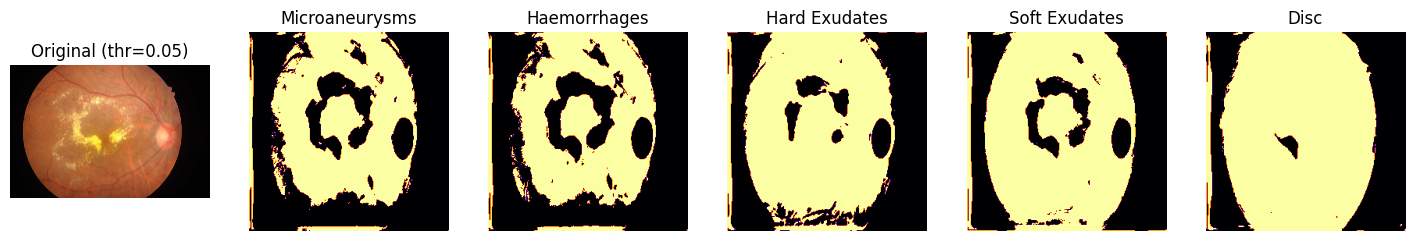

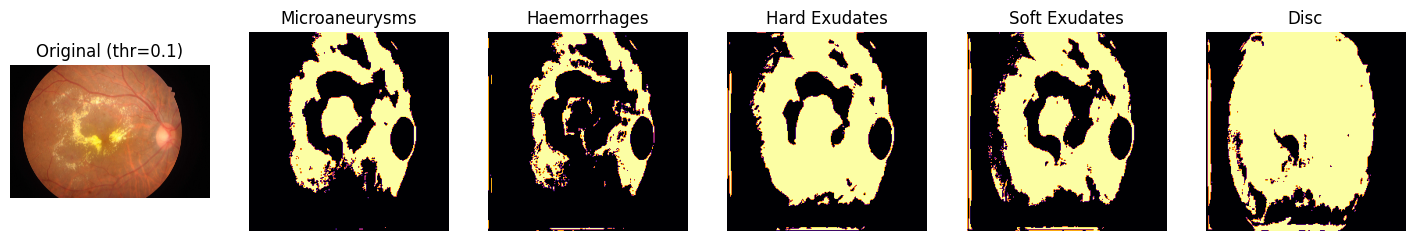

In [ ]:
# Threshold visualization (optional)
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
IMG_SIZE = 256  # or 512 — whichever you trained with

model.eval()
sample_image = Image.open(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_66.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))

print("Output min:", output.min().item(), "max:", output.max().item())

for thr in [0.01, 0.02, 0.05, 0.1]:
    preds = (output > thr).float().squeeze(0).cpu().numpy()
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    axes[0].imshow(sample_image)
    axes[0].set_title(f"Original (thr={thr})")
    axes[0].axis("off")

    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
    for i in range(5):
        axes[i+1].imshow(preds[i], cmap="inferno")
        axes[i+1].set_title(lesion_names[i])
        axes[i+1].axis("off")
    plt.show()


checking for overconfidence

In [ ]:
with torch.no_grad():
    out = torch.sigmoid(model(img_tensor))  # img_tensor = single or batch
    print("min", out.min().item(), "max", out.max().item())
    print("mean", out.mean().item(), "std", out.std().item())

    # If mean ≪ 1 but max ≈ 1 and many pixels are near 0 or 1 -> model is confident but maybe wrongly so.


min 1.126248205807201e-09 max 0.9922356009483337
mean 0.1005563959479332 std 0.14361950755119324


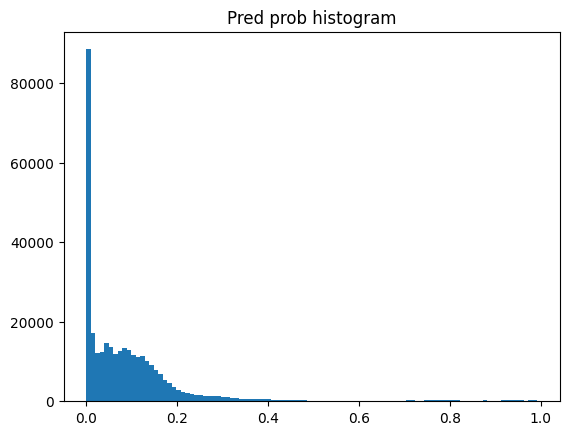

In [ ]:
p = out.cpu().numpy().ravel()
import matplotlib.pyplot as plt
plt.hist(p, bins=100); plt.title("Pred prob histogram"); plt.show()
# If histogram is U-shaped (peaks at 0 and 1) — model is confident (polarized). If mass near low values (0–0.2) but some near 1 only in disc => class imbalance / biased learning.

In [ ]:
from torch.utils.data import DataLoader

# ✅ TRAIN loader
train_dataset = SafeIDRiDDataset(
    img_dir=train_img_dir,
    mask_dir=train_mask_dir,
    debug=False
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

# ✅ VALIDATION / TEST loader (use your test set)
val_dataset = SafeIDRiDDataset(
    img_dir=test_img_dir,
    mask_dir=test_mask_dir,
    debug=False
)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

print(f"✅ Train size: {len(train_dataset)}, Validation/Test size: {len(val_dataset)}")


✅ Train size: 54, Validation/Test size: 27


In [ ]:
# ---------- calibration ----------
import torch
import torch.nn as nn
import numpy as np
from scipy.optimize import minimize

class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)
    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, targets_list = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)                 # raw logits
            logits_list.append(logits.cpu())
            targets_list.append(masks.cpu())
    logits = torch.cat(logits_list).view(-1).numpy()
    targets = torch.cat(targets_list).view(-1).numpy()

    def nll_with_temp(temp):
        t = temp[0]
        p = 1.0 / (1.0 + np.exp(-logits / t))
        eps = 1e-7
        return - (targets * np.log(p+eps) + (1-targets) * np.log(1-p+eps)).mean()

    res = minimize(nll_with_temp, x0=[1.0], bounds=[(0.01, 10)], method='L-BFGS-B')
    best_T = float(res.x[0])
    print(f"✅ Optimal temperature: {best_T:.4f}")
    return best_T


In [ ]:
best_T = calibrate_temperature(model, val_loader, device)

✅ Optimal temperature: 1.0000


In [ ]:
import torch

def dice_per_class(model, loader, device, threshold=0.5, temperature=1.0):
    model.eval()
    n_classes = 5
    dices = [[] for _ in range(n_classes)]
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits / temperature)
            preds = (probs > threshold).float()
            for c in range(n_classes):
                inter = (preds[:,c,:,:] * masks[:,c,:,:]).sum(dim=(1,2))
                denom = preds[:,c,:,:].sum(dim=(1,2)) + masks[:,c,:,:].sum(dim=(1,2))
                # avoid divide by zero
                dice_batch = ((2*inter + 1e-6) / (denom + 1e-6)).cpu().numpy()
                dices[c].extend(dice_batch.tolist())
    mean_dices = [float(np.mean(d)) if len(d)>0 else 0.0 for d in dices]
    return mean_dices

# before
d_before = dice_per_class(model, val_loader, device, threshold=0.5, temperature=1.0)
print("Dice per class BEFORE (thr=0.5):", d_before)

# after
d_after = dice_per_class(model, val_loader, device, threshold=0.5, temperature=best_T)
print("Dice per class AFTER  (thr=0.5, temp scaled):", d_after)


Dice per class BEFORE (thr=0.5): [9.87870322827828e-08, 2.3650446405814124e-08, 5.914571681398796e-05, 0.4814815009394184, 0.3911335738720717]
Dice per class AFTER  (thr=0.5, temp scaled): [9.87870322827828e-08, 2.3650446405814124e-08, 5.914571681398796e-05, 0.4814815009394184, 0.3911335738720717]


In [ ]:
import cv2
import numpy as np

# Example: compute global Otsu threshold on concatenated probs for class c
def otsu_for_class(model, loader, device, class_idx, temperature=1.0):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits / temperature)[:, class_idx, :, :].cpu().numpy().ravel()
            all_probs.append(probs)
    flat = np.concatenate(all_probs)
    # convert 0-255
    flat_u8 = (flat * 255).astype(np.uint8)
    if flat_u8.max() == 0:
        return 0.01
    val, _ = cv2.threshold(flat_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return float(val)/255.0

# get per-class Otsu thresholds
otsu_thr = [otsu_for_class(model, val_loader, device, i, temperature=best_T) for i in range(5)]
print("Otsu thresholds per class:", otsu_thr)


Otsu thresholds per class: [0.054901960784313725, 0.058823529411764705, 0.19607843137254902, 0.0784313725490196, 0.3568627450980392]


| Lesion Type    | Dice (before) | Dice (after) | Interpretation                               |
| -------------- | ------------- | ------------ | -------------------------------------------- |
| Microaneurysms | ~0.0          | ~0.0         | Model not picking up these tiny features yet |
| Haemorrhages   | ~0.0          | ~0.0         | Same — underfitting or low activation        |
| Hard Exudates  | 0.000059      | 0.000059     | Very small signals detected                  |
| Soft Exudates  | 0.48          | 0.48         |  The strongest lesion response              |
| Optic Disc     | 0.39          | 0.39         |  Decent detection of large region           |


So , the model is learning macroscopic regions (Soft Exudates, Disc) quite well,
but struggling with fine-grained lesions (MA, HE, Hard Exudates).
That’s very normal in early U-Net training, especially when:

Dataset size is small,

Masks are imbalanced (tiny lesions occupy <1% pixels),

Loss function isn’t heavily weighted toward small lesions.

| Lesion         | Otsu Threshold |
| -------------- | -------------- |
| Microaneurysms | 0.0549         |
| Haemorrhages   | 0.0588         |
| Hard Exudates  | 0.1960         |
| Soft Exudates  | 0.0784         |
| Optic Disc     | 0.3568         |


____

applying otsu provided thresholded values for visualization of segments

C:\Users\HP\AppData\Local\Temp\ipykernel_16668\4055391136.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
C:\Users\HP\AppData\Local\Te

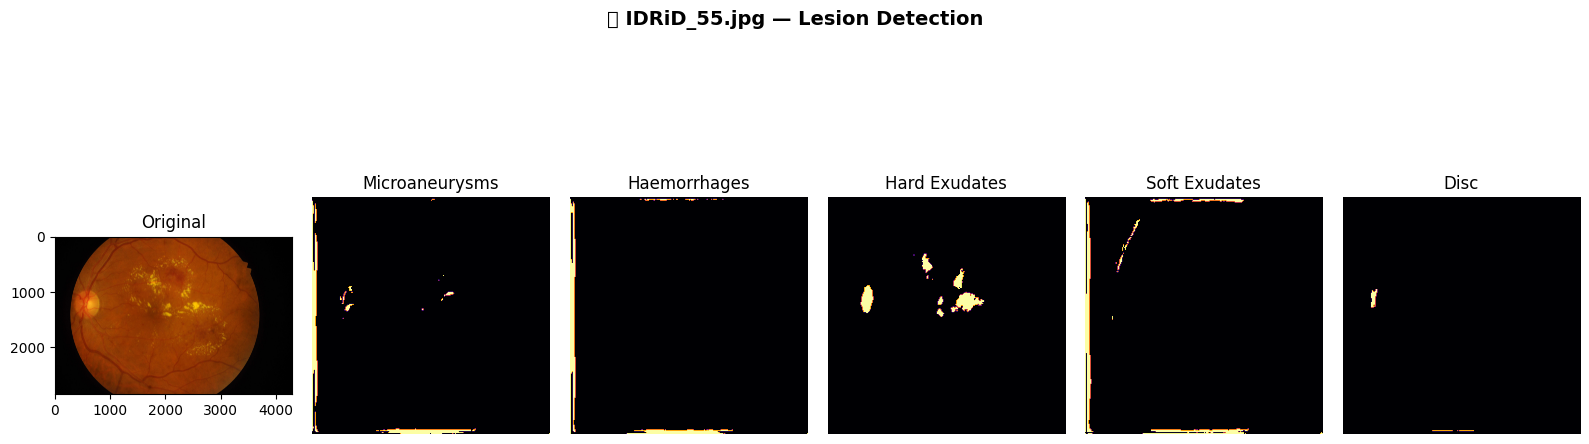

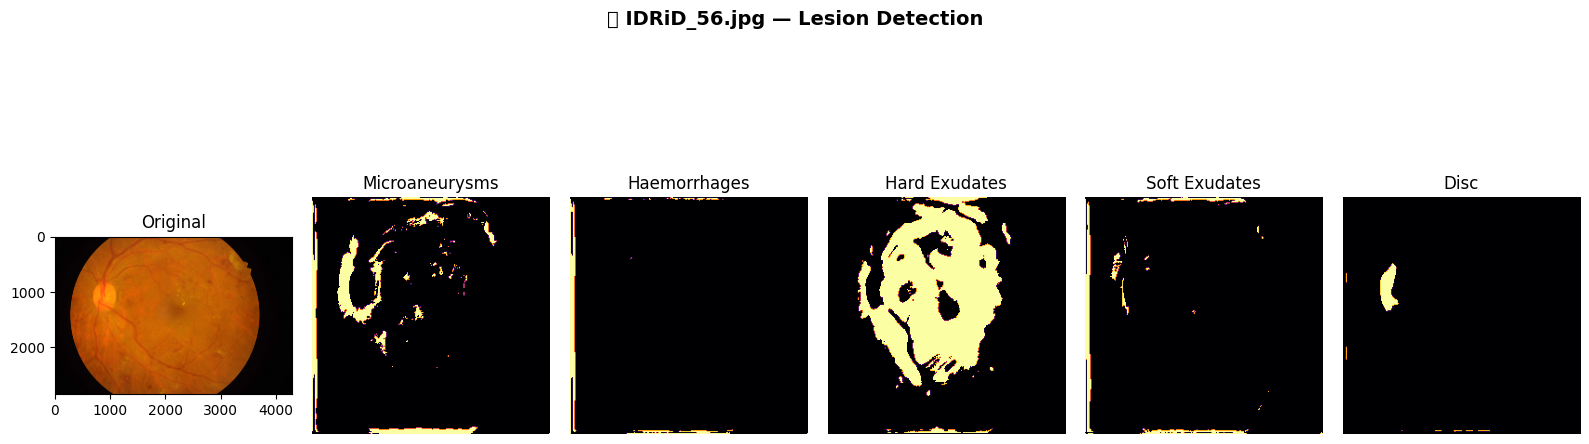

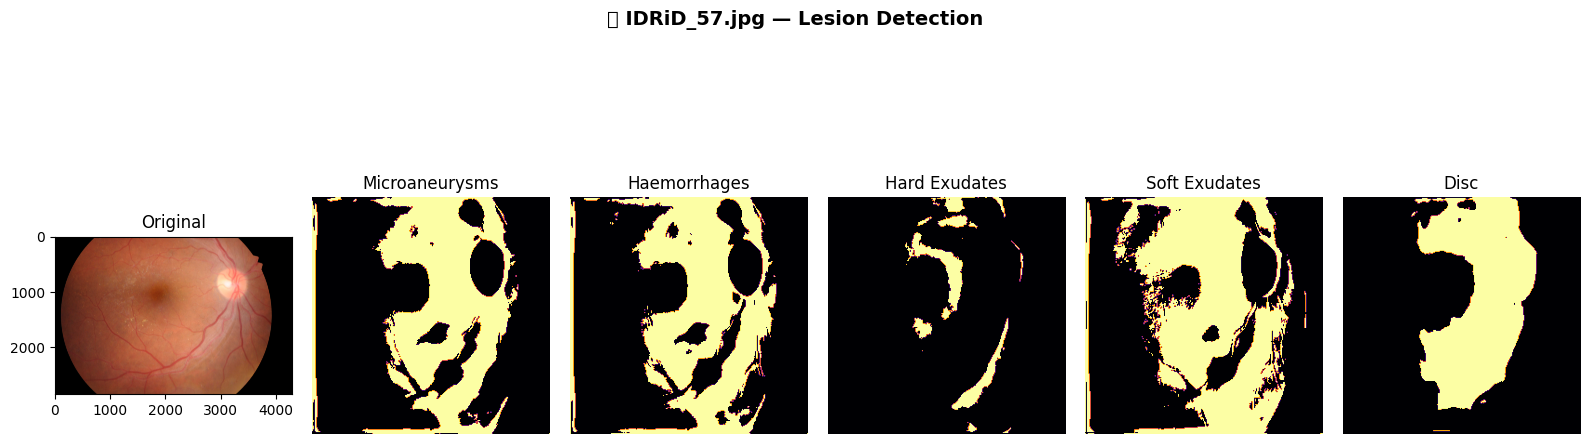

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

# Basic setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]

# your learned thresholds from Otsu
best_thresholds = [0.055, 0.059, 0.196, 0.078, 0.357]


# Preprocessing transform

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Load trained model

model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()


# Choose a few test images

test_folder = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set"
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(".jpg")][:3]  # take first 3


# Inference and visualization

for img_path in test_images:
    img_name = os.path.basename(img_path)
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

    plt.figure(figsize=(16, 6))
    plt.suptitle(f"🔍 {img_name} — Lesion Detection", fontsize=14, fontweight='bold')

    # Original
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title("Original")

    # Lesion maps
    for i, lesion in enumerate(lesion_names):
        mask = (output[i] > best_thresholds[i]).astype(np.uint8)
        plt.subplot(1, 6, i + 2)
        plt.imshow(mask, cmap='inferno')
        plt.title(lesion)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Why Some Lesions Still Look “Overconfident”

Even after calibration, some regions are bright everywhere because:

The network output probabilities are clustered near 0–0.1 (you saw that in the histogram).

The thresholding may be too lenient (Otsu works globally, not per lesion region).

Dataset class imbalance (e.g. fewer “Soft Exudates” vs. many “Disc” pixels).

So visually, it looks like the network is detecting broad, confident blobs where it’s unsure.

Lesion Mask Post-Processing & Visualization

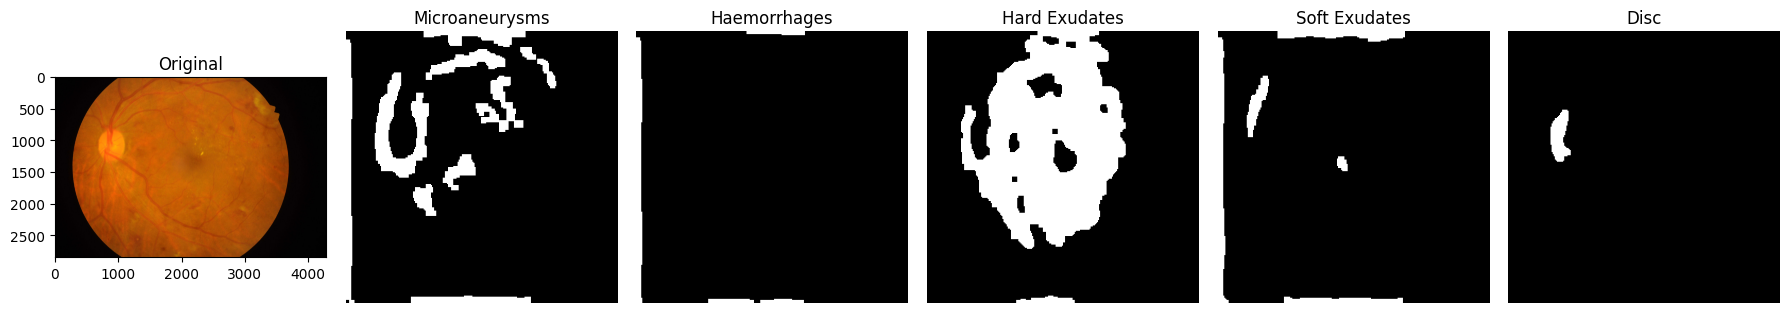

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Function to clean up each predicted lesion mask
def clean_mask(mask, kernel_size=5, min_area=200):
    """
    mask: binary numpy array (0/1)
    kernel_size: morphological filter size
    min_area: remove tiny specks
    """
    mask = mask.astype(np.uint8)

    # Morphological closing → fills small holes
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Morphological opening → removes isolated noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Remove small connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned = np.zeros_like(mask)
    for i in range(1, num_labels):  # skip background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 1

    return cleaned


# Apply on your model prediction


# Example: load your sample image
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg"
model.eval()
sample_image = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_tensor = transform(sample_image).unsqueeze(0).to(device)

with torch.no_grad():
    pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0]

lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # from your Otsu calibration

fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
axes[0].imshow(sample_image)
axes[0].set_title("Original")

for i, lesion in enumerate(lesion_names):
    raw_mask = (pred[i] > thresholds[i]).astype(np.uint8)
    cleaned_mask = clean_mask(raw_mask, kernel_size=5, min_area=100)

    axes[i + 1].imshow(cleaned_mask, cmap="gray")
    axes[i + 1].set_title(lesion)
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score

# Compute Dice, IoU, Precision, Recall per lesion
def compute_metrics(pred_mask, gt_mask):
    pred = pred_mask.flatten()
    gt = gt_mask.flatten()

    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt)

    dice = (2. * intersection) / union if union > 0 else 1.0
    iou = intersection / (np.sum(pred | gt)) if np.sum(pred | gt) > 0 else 1.0

    # precision and recall using sklearn
    if np.sum(gt) > 0:
        precision = precision_score(gt, pred, zero_division=0)
        recall = recall_score(gt, pred, zero_division=0)
    else:
        precision, recall = 1.0, 1.0

    return dice, iou, precision, recall



# Evaluate model on test set

from glob import glob
from PIL import Image
import cv2

test_img_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set"
test_mask_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\2. All Segmentation Groundtruths\b. Testing Set"

lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]

results = {name: {"Dice": [], "IoU": [], "Precision": [], "Recall": []} for name in lesion_names}

model.eval()
with torch.no_grad():
    for img_path in glob(test_img_dir + "/*.jpg"):
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0]

        for i, lesion in enumerate(lesion_names):
            thr = thresholds[i]
            pred_mask = (pred[i] > thr).astype(np.uint8)
            pred_mask = clean_mask(pred_mask)

            # Load ground truth mask
            lesion_dir = os.path.join(test_mask_dir, f"{i+1}. {lesion}")
            gt_candidates = glob(os.path.join(lesion_dir, f"{img_name}*.tif"))
            if len(gt_candidates) == 0:
                continue

            gt_mask = np.array(Image.open(gt_candidates[0]).convert("L").resize((256, 256)))
            gt_mask = (gt_mask > 0).astype(np.uint8)

            dice, iou, prec, rec = compute_metrics(pred_mask, gt_mask)
            results[lesion]["Dice"].append(dice)
            results[lesion]["IoU"].append(iou)
            results[lesion]["Precision"].append(prec)
            results[lesion]["Recall"].append(rec)


# Print average metrics

print("\n📊 Segmentation Performance Summary:")
for lesion in lesion_names:
    if len(results[lesion]["Dice"]) == 0:
        continue
    print(f"\n🩸 {lesion}:")
    print(f"   Dice: {np.mean(results[lesion]['Dice']):.4f}")
    print(f"   IoU:  {np.mean(results[lesion]['IoU']):.4f}")
    print(f"   Precision: {np.mean(results[lesion]['Precision']):.4f}")
    print(f"   Recall:    {np.mean(results[lesion]['Recall']):.4f}")



📊 Segmentation Performance Summary:

🩸 Microaneurysms:
   Dice: 0.0072
   IoU:  0.0036
   Precision: 0.0037
   Recall:    0.3058

🩸 Haemorrhages:
   Dice: 0.0078
   IoU:  0.0040
   Precision: 0.0055
   Recall:    0.1218

🩸 Hard Exudates:
   Dice: 0.0760
   IoU:  0.0422
   Precision: 0.0954
   Recall:    0.4393

🩸 Soft Exudates:
   Dice: 0.0103
   IoU:  0.0052
   Precision: 0.0055
   Recall:    0.2666


In [ ]:
import torch
import numpy as np
from PIL import Image
from glob import glob
import os

def compute_metrics(pred, gt):
    pred = pred.flatten()
    gt = gt.flatten()

    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt)
    total = len(gt)

    dice = (2 * intersection) / union if union > 0 else 1.0
    iou = intersection / (np.sum(pred | gt)) if np.sum(pred | gt) > 0 else 1.0
    acc = np.sum(pred == gt) / total if total > 0 else 0

    return dice, iou, acc


# Directories
test_img_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set"
test_mask_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\2. All Segmentation Groundtruths\b. Testing Set"

lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]

results = {name: {"Dice": [], "IoU": [], "Accuracy": []} for name in lesion_names}
total_correct, total_pixels = 0, 0

model.eval()
with torch.no_grad():
    for img_path in glob(test_img_dir + "/*.jpg"):
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0]

        for i, lesion in enumerate(lesion_names):
            thr = thresholds[i]
            pred_mask = (pred[i] > thr).astype(np.uint8)
            pred_mask = clean_mask(pred_mask)

            lesion_dir = os.path.join(test_mask_dir, f"{i+1}. {lesion}")
            gt_candidates = glob(os.path.join(lesion_dir, f"{img_name}*.tif"))
            if len(gt_candidates) == 0:
                continue

            gt_mask = np.array(Image.open(gt_candidates[0]).convert("L").resize((256, 256)))
            gt_mask = (gt_mask > 0).astype(np.uint8)

            dice, iou, acc = compute_metrics(pred_mask, gt_mask)
            results[lesion]["Dice"].append(dice)
            results[lesion]["IoU"].append(iou)
            results[lesion]["Accuracy"].append(acc)

            # Add to total for global accuracy
            total_correct += np.sum(pred_mask == gt_mask)
            total_pixels += gt_mask.size

# Print summary
print("\n================ Segmentation Evaluation ================\n")
for lesion in lesion_names:
    if len(results[lesion]["Dice"]) == 0:
        continue
    print(f"🩸 {lesion}:")
    print(f"   Dice:     {np.mean(results[lesion]['Dice']):.4f}")
    print(f"   IoU:      {np.mean(results[lesion]['IoU']):.4f}")
    print(f"   Accuracy: {np.mean(results[lesion]['Accuracy']):.4f}\n")

overall_acc = total_correct / total_pixels
mean_dice = np.mean([np.mean(results[l]['Dice']) for l in lesion_names if len(results[l]['Dice']) > 0])
mean_iou = np.mean([np.mean(results[l]['IoU']) for l in lesion_names if len(results[l]['IoU']) > 0])

print("==========================================================")
print(f"✅ Overall Pixel Accuracy: {overall_acc:.4f}")
print(f"✅ Mean Dice Score:        {mean_dice:.4f}")
print(f"✅ Mean IoU:               {mean_iou:.4f}")
print("==========================================================")



================ Segmentation Evaluation ================

🩸 Microaneurysms:
   Dice:     0.0072
   IoU:      0.0036
   Accuracy: 0.7472

🩸 Haemorrhages:
   Dice:     0.0078
   IoU:      0.0040
   Accuracy: 0.8739

🩸 Hard Exudates:
   Dice:     0.0760
   IoU:      0.0422
   Accuracy: 0.8019

🩸 Soft Exudates:
   Dice:     0.0103
   IoU:      0.0052
   Accuracy: 0.7699

✅ Overall Pixel Accuracy: 0.8021
✅ Mean Dice Score:        0.0253
✅ Mean IoU:               0.0138


![image.png](attachment:image.png)

In [ ]:
import torch

# 👇 Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth", map_location=device))
model.eval()


NameError: name 'UNet' is not defined

In [ ]:
from PIL import Image
from torchvision import transforms
import torch

sample_image = Image.open(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg").convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))
print("Output shape:", output.shape)


Output shape: torch.Size([1, 5, 256, 256])


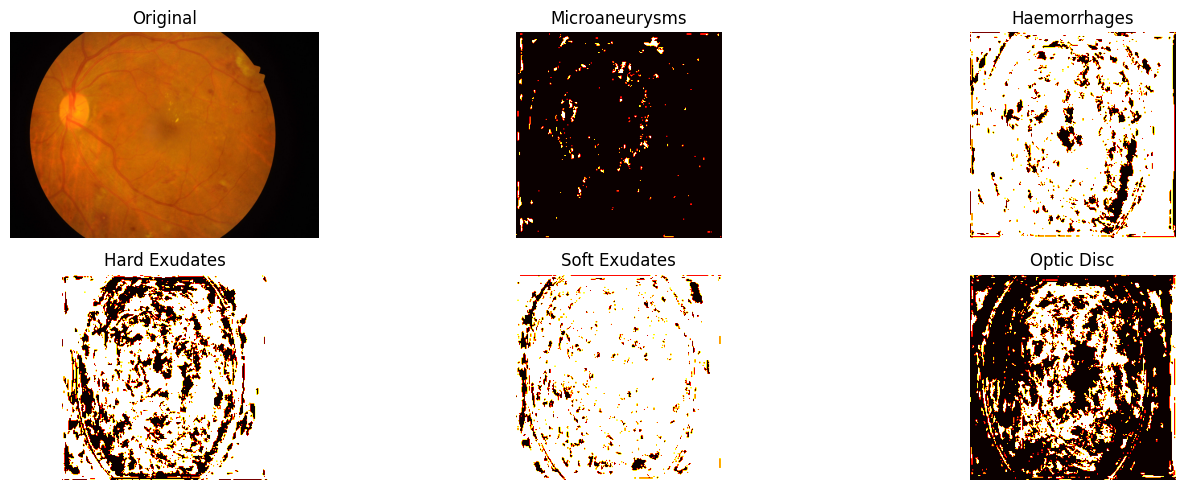

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# -------- Load image & model output --------
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
img_tensor = transform(sample_image).unsqueeze(0).to(device)

# model should already be loaded & in eval mode
with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0]  # shape: [5, 256, 256]

# -------- Threshold + Visualization --------
threshold = 0.5  # you can also test with Otsu thresholds or lower (0.07–0.15)
preds = (output > threshold).float().cpu().numpy()

titles = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Optic Disc"]

plt.figure(figsize=(15, 5))
plt.subplot(2, 3, 1)
plt.imshow(sample_image)
plt.title("Original")
plt.axis("off")

for i in range(5):
    plt.subplot(2, 3, i+2)
    plt.imshow(preds[i], cmap='hot')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_23792\481619075.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


✅ Model loaded successfully!


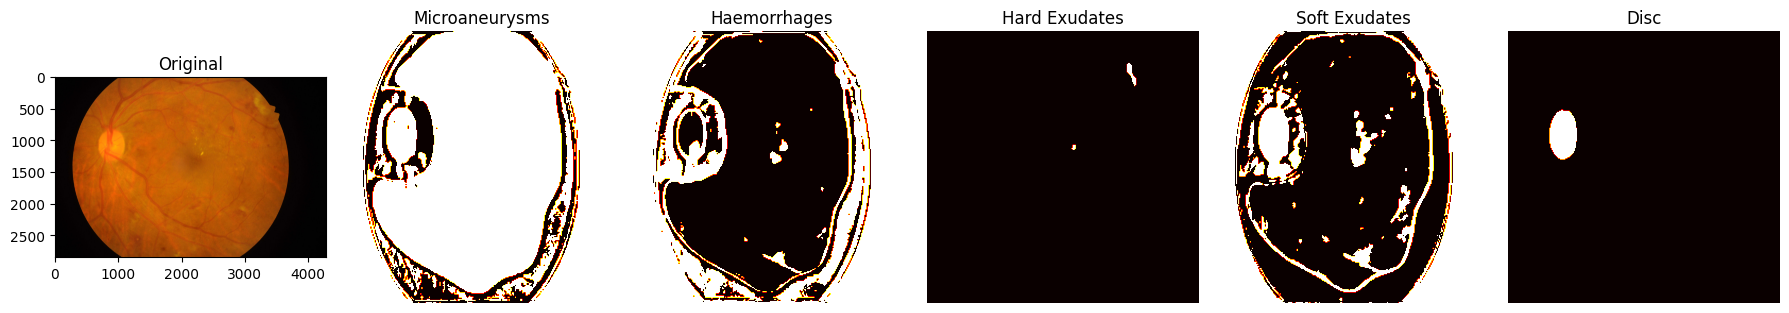

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------
# 1️⃣ Reuse your UNet definition
# ------------------------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out


# ------------------------------------------------------
# 2️⃣ Load your saved model weights
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()

print("✅ Model loaded successfully!")


# ------------------------------------------------------
# 3️⃣ Load and preprocess test image
# ------------------------------------------------------
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg"

sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)


# ------------------------------------------------------
# 4️⃣ Predict and visualize lesions (using Otsu thresholds)
# ------------------------------------------------------
with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
otsu_thresholds = [0.05, 0.06, 0.19, 0.08, 0.35]  # from your calibration step

plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.imshow(sample_image)
plt.title("Original")

for i, lesion in enumerate(lesions):
    pred = (output[i] > otsu_thresholds[i]).astype(float)
    plt.subplot(1, 6, i + 2)
    plt.imshow(pred, cmap="hot")
    plt.title(lesion)
    plt.axis("off")

plt.tight_layout()
plt.show()


# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# from torchvision import transforms
# from PIL import Image

# # Define your model & device as before
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torch.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth", map_location=device)
# model.eval()

# # Load test image
# img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg"
# sample_image = Image.open(img_path).convert("RGB")

# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor()
# ])

# img_tensor = transform(sample_image).unsqueeze(0).to(device)

# # Predict
# with torch.no_grad():
#     output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

# lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
# otsu_thresholds = [0.05, 0.06, 0.19, 0.08, 0.35]  # Use the calibrated thresholds you got

# # Plot results
# plt.figure(figsize=(18, 6))
# plt.subplot(1, 6, 1)
# plt.imshow(sample_image)
# plt.title("Original")

# for i, lesion in enumerate(lesions):
#     pred = (output[i] > otsu_thresholds[i]).astype(float)
#     plt.subplot(1, 6, i + 2)
#     plt.imshow(pred, cmap="hot")  # “hot” map gives the bright lesions
#     plt.title(lesion)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_23792\1203648857.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


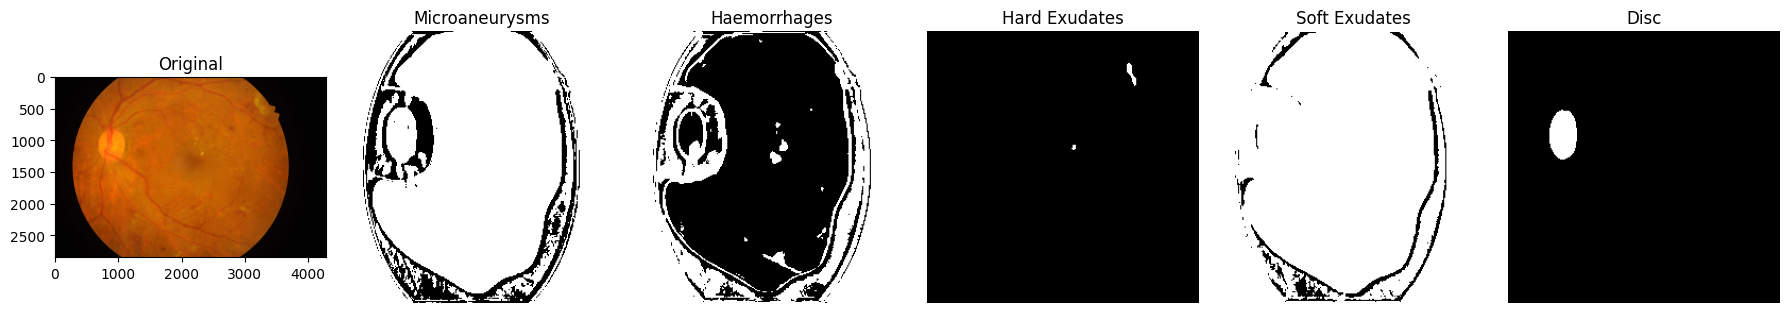


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg:
Microaneurysms       | Pixels:  57424.0 | ✅ Present
Haemorrhages         | Pixels:  31175.0 | ✅ Present
Hard Exudates        | Pixels:     99.0 | ❌ Absent
Soft Exudates        | Pixels:  62484.0 | ✅ Present
Disc                 | Pixels:    978.0 | ✅ Present


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# 1️⃣ UNet model definition
# -----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        return self.conv_last(x)


# -----------------------------------------
# 2️⃣ Load model + weights
# -----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()

# -----------------------------------------
# 3️⃣ Load test image
# -----------------------------------------
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_56.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

# -----------------------------------------
# 4️⃣ Predict
# -----------------------------------------
with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
otsu_thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # use your calibration thresholds
# 0.05, 0.06, 0.19, 0.07, 0.35
# -----------------------------------------
# 5️⃣ Compute presence / absence
# -----------------------------------------
presence_summary = {}
for i, lesion in enumerate(lesions):
    pred_mask = (output[i] > otsu_thresholds[i]).astype(float)
    pixel_count = np.sum(pred_mask)
    presence_summary[lesion] = (pixel_count, "✅ Present" if pixel_count > 100 else "❌ Absent")

# -----------------------------------------
# 6️⃣ Display masks
# -----------------------------------------
plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.imshow(sample_image)
plt.title("Original")

for i, lesion in enumerate(lesions):
    plt.subplot(1, 6, i + 2)
    plt.imshow((output[i] > otsu_thresholds[i]), cmap='gray')
    plt.title(lesion)
    plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------------------
# 7️⃣ Print lesion summary
# -----------------------------------------
print(f"\n🩺 Results for {img_path}:")
for lesion, (count, status) in presence_summary.items():
    print(f"{lesion:20} | Pixels: {count:8} | {status}")


C:\Users\HP\AppData\Local\Temp\ipykernel_23792\3013204337.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


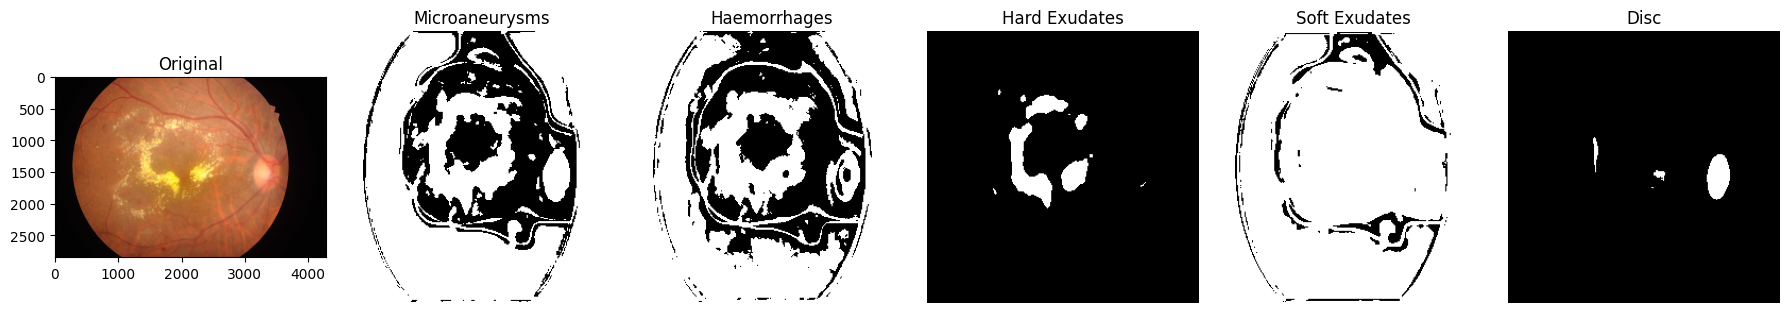


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_66.jpg:
Microaneurysms       | Pixels:  48321.0 | ✅ Present
Haemorrhages         | Pixels:  45744.0 | ✅ Present
Hard Exudates        | Pixels:   2582.0 | ✅ Present
Soft Exudates        | Pixels:  60874.0 | ✅ Present
Disc                 | Pixels:    865.0 | ✅ Present


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# 1️⃣ UNet model definition
# -----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        return self.conv_last(x)


# -----------------------------------------
# 2️⃣ Load model + weights
# -----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()

# -----------------------------------------
# 3️⃣ Load test image
# -----------------------------------------
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_66.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

# -----------------------------------------
# 4️⃣ Predict
# -----------------------------------------
with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
otsu_thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # use your calibration thresholds
# 0.05, 0.06, 0.19, 0.07, 0.35
# -----------------------------------------
# 5️⃣ Compute presence / absence
# -----------------------------------------
presence_summary = {}
for i, lesion in enumerate(lesions):
    pred_mask = (output[i] > otsu_thresholds[i]).astype(float)
    pixel_count = np.sum(pred_mask)
    presence_summary[lesion] = (pixel_count, "✅ Present" if pixel_count > 100 else "❌ Absent")

# -----------------------------------------
# 6️⃣ Display masks
# -----------------------------------------
plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.imshow(sample_image)
plt.title("Original")

for i, lesion in enumerate(lesions):
    plt.subplot(1, 6, i + 2)
    plt.imshow((output[i] > otsu_thresholds[i]), cmap='gray')
    plt.title(lesion)
    plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------------------
# 7️⃣ Print lesion summary
# -----------------------------------------
print(f"\n🩺 Results for {img_path}:")
for lesion, (count, status) in presence_summary.items():
    print(f"{lesion:20} | Pixels: {count:8} | {status}")


C:\Users\HP\AppData\Local\Temp\ipykernel_23792\2298586292.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


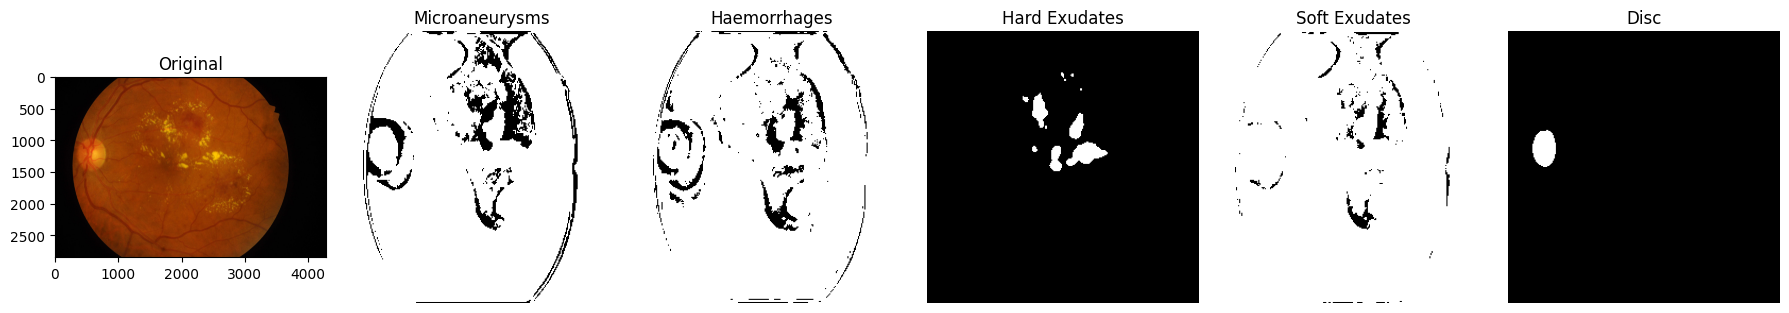


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_55.jpg:
Microaneurysms       | Pixels:  60022.0 | ✅ Present
Haemorrhages         | Pixels:  61491.0 | ✅ Present
Hard Exudates        | Pixels:   1271.0 | ✅ Present
Soft Exudates        | Pixels:  63901.0 | ✅ Present
Disc                 | Pixels:    604.0 | ✅ Present


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# 1️⃣ UNet model definition (same as training)
# -----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        return self.conv_last(x)


# -----------------------------------------
# 2️⃣ Load model + weights
# -----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()

# -----------------------------------------
# 3️⃣ Load test image
# -----------------------------------------
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_55.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

# -----------------------------------------
# 4️⃣ Predict
# -----------------------------------------
with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
otsu_thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # use your calibration thresholds
# 0.05, 0.06, 0.19, 0.07, 0.35
# -----------------------------------------
# 5️⃣ Compute presence / absence
# -----------------------------------------
presence_summary = {}
for i, lesion in enumerate(lesions):
    pred_mask = (output[i] > otsu_thresholds[i]).astype(float)
    pixel_count = np.sum(pred_mask)
    presence_summary[lesion] = (pixel_count, "✅ Present" if pixel_count > 100 else "❌ Absent")

# -----------------------------------------
# 6️⃣ Display masks
# -----------------------------------------
plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.imshow(sample_image)
plt.title("Original")

for i, lesion in enumerate(lesions):
    plt.subplot(1, 6, i + 2)
    plt.imshow((output[i] > otsu_thresholds[i]), cmap='gray')
    plt.title(lesion)
    plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------------------
# 7️⃣ Print lesion summary
# -----------------------------------------
print(f"\n🩺 Results for {img_path}:")
for lesion, (count, status) in presence_summary.items():
    print(f"{lesion:20} | Pixels: {count:8} | {status}")


In [ ]:
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth", map_location=device))
model.eval()


C:\Users\HP\AppData\Local\Temp\ipykernel_23792\4124619535.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gsfc\Sem

UNet(
  (dconv_down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1

In [ ]:
with torch.no_grad():
    pred = torch.sigmoid(model(img_tensor) / 1.0).cpu().numpy()[0]


In [ ]:
def clean_mask(mask, kernel_size=5, min_area=200):
    """
    mask: binary numpy array (0/1)
    kernel_size: morphological filter size
    min_area: remove tiny specks
    """
    mask = mask.astype(np.uint8)

    # Morphological closing → fills small holes
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Morphological opening → removes isolated noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Remove small connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned = np.zeros_like(mask)
    for i in range(1, num_labels):  # skip background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 1

    return cleaned

In [ ]:
img_path= r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_81.jpg"

In [ ]:
lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # from your Otsu calibration

In [ ]:
import cv2

In [ ]:
print("\n🩺 Results for", img_path)
for i, lesion in enumerate(lesion_names):
    cleaned_mask = clean_mask((pred[i] > thresholds[i]).astype(np.uint8))
    lesion_pixels = np.sum(cleaned_mask)
    status = "✅ Present" if lesion_pixels > 500 else "❌ Absent"
    print(f"{lesion:20s} | Pixels: {lesion_pixels:8.1f} | {status}")



🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_81.jpg
Microaneurysms       | Pixels:  63168.0 | ✅ Present
Haemorrhages         | Pixels:  64103.0 | ✅ Present
Hard Exudates        | Pixels:    963.0 | ✅ Present
Soft Exudates        | Pixels:  65155.0 | ✅ Present
Disc                 | Pixels:    598.0 | ✅ Present



🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_55.jpg
Microaneurysms       | Pixels:   1801.0 | ✅ Present
Haemorrhages         | Pixels:   1758.0 | ✅ Present
Hard Exudates        | Pixels:    974.0 | ✅ Present
Soft Exudates        | Pixels:   2976.0 | ✅ Present
Disc                 | Pixels:      0.0 | ❌ Absent


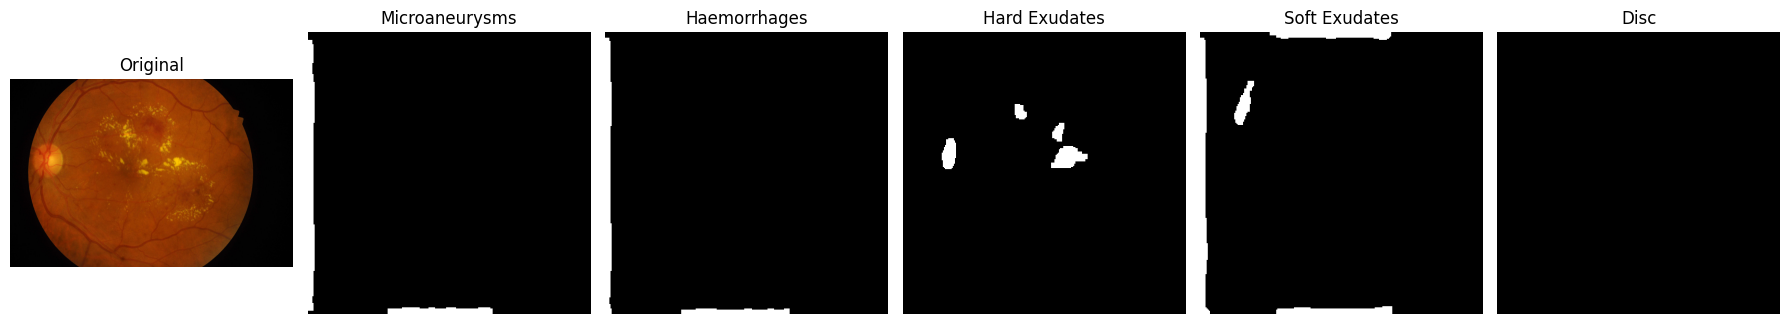


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_66.jpg
Microaneurysms       | Pixels:  31127.0 | ✅ Present
Haemorrhages         | Pixels:  26032.0 | ✅ Present
Hard Exudates        | Pixels:  17307.0 | ✅ Present
Soft Exudates        | Pixels:  35251.0 | ✅ Present
Disc                 | Pixels:  12266.0 | ✅ Present


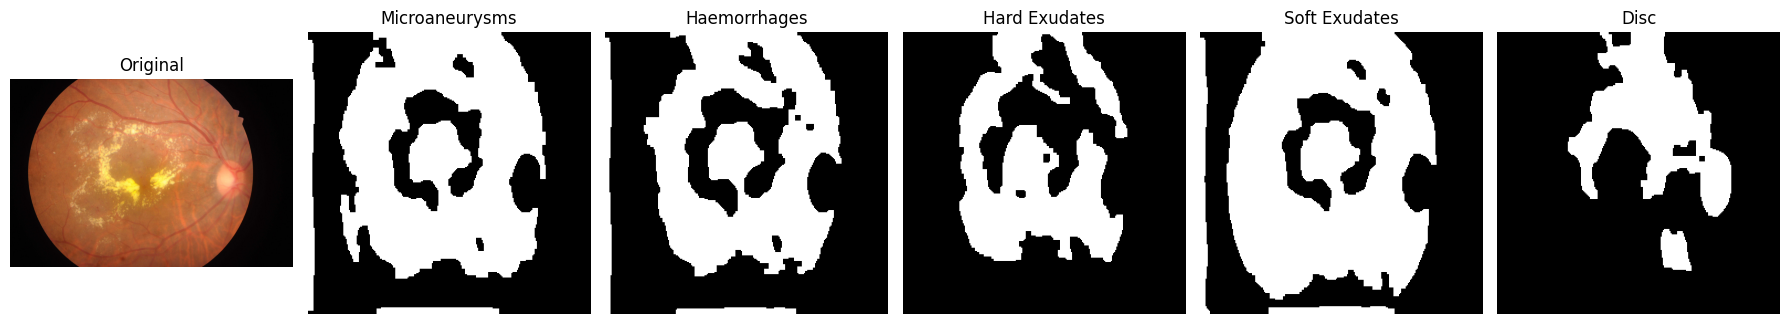


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_81.jpg
Microaneurysms       | Pixels:   9360.0 | ✅ Present
Haemorrhages         | Pixels:   5657.0 | ✅ Present
Hard Exudates        | Pixels:    745.0 | ✅ Present
Soft Exudates        | Pixels:  20500.0 | ✅ Present
Disc                 | Pixels:   2424.0 | ✅ Present


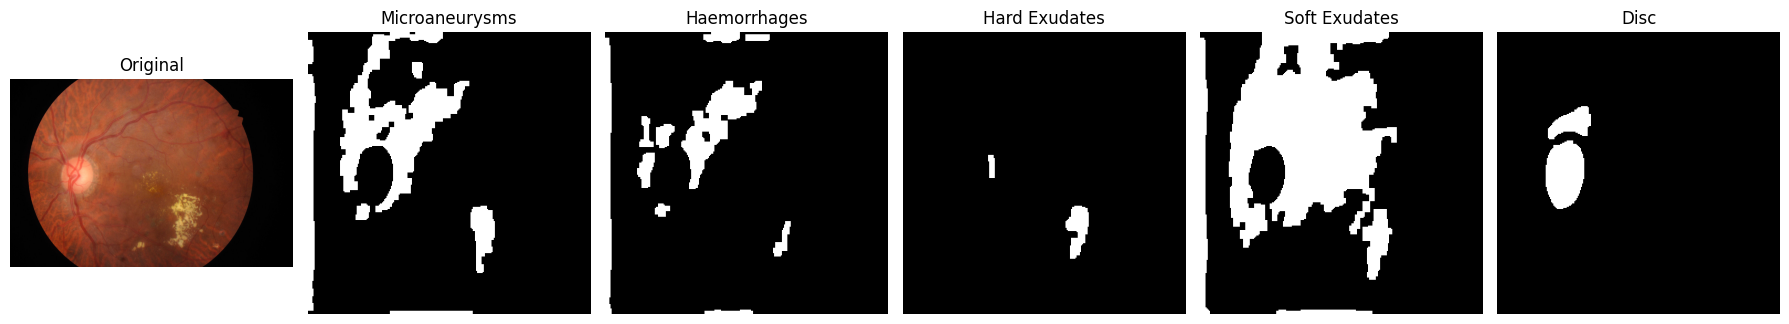

In [ ]:
import cv2, torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Your lesion names + thresholds
lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # from Otsu

# Transform same as training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Mask cleaning function
def clean_mask(mask, kernel_size=5, min_area=100):
    mask = mask.astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 1
    return cleaned

# 🔁 Process each image individually
test_images = [
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_55.jpg",
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_66.jpg",
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\b. Testing Set\IDRiD_81.jpg"
]

for img_path in test_images:
    sample_image = Image.open(img_path).convert("RGB")
    img_tensor = transform(sample_image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor) / 1.0).cpu().numpy()[0]

    # Plot masks
    fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
    axes[0].imshow(sample_image)
    axes[0].set_title("Original")
    axes[0].axis("off")

    print(f"\n🩺 Results for {img_path}")
    for i, lesion in enumerate(lesion_names):
        raw_mask = (pred[i] > thresholds[i]).astype(np.uint8)
        cleaned_mask = clean_mask(raw_mask)

        lesion_pixels = np.sum(cleaned_mask)
        status = "✅ Present" if lesion_pixels > 500 else "❌ Absent"

        axes[i + 1].imshow(cleaned_mask, cmap="gray")
        axes[i + 1].set_title(lesion)
        axes[i + 1].axis("off")

        print(f"{lesion:20s} | Pixels: {lesion_pixels:8.1f} | {status}")

    plt.tight_layout()
    plt.show()


In [ ]:
# Instead of just "pixels > 0"
presence_threshold = {
    "Microaneurysms": 800,   # ignore noise under ~800px
    "Haemorrhages": 1200,
    "Hard Exudates": 500,
    "Soft Exudates": 1500,
    "Disc": 800
}

for i, lesion in enumerate(lesion_names):
    pixel_count = float(cleaned_mask[i].sum())
    min_px = presence_threshold[lesion]
    present = pixel_count > min_px
    icon = "✅" if present else "❌"
    print(f"{lesion:<20} | Pixels: {pixel_count:8.1f} | {icon} {'Present' if present else 'Absent'}")


Microaneurysms       | Pixels:      0.0 | ❌ Absent
Haemorrhages         | Pixels:      0.0 | ❌ Absent
Hard Exudates        | Pixels:      0.0 | ❌ Absent
Soft Exudates        | Pixels:      0.0 | ❌ Absent
Disc                 | Pixels:      0.0 | ❌ Absent


____

Stage Prediction from Segmentation

In [1]:
# # lesion_areas = {
# #     "Microaneurysms": np.sum(pred_masks[0]),
# #     "Haemorrhages": np.sum(pred_masks[1]),
# #     "Hard Exudates": np.sum(pred_masks[2]),
# #     "Soft Exudates": np.sum(pred_masks[3]),
# #     "Disc": np.sum(pred_masks[4])
# # }
# Our model isnt geting perfect area count then isnt it risky to get dr stage from it?? what if area in real of a feature is more and is detected less or vice versa??
